# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [50]:
import torch
import torchvision
import matplotlib.pyplot as pl
import random
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [51]:
batch_size_train = 64
batch_size_test = 1000

In [52]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [53]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

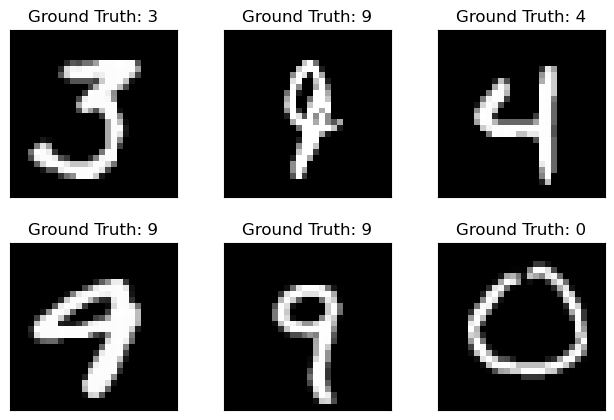

In [54]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [55]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [56]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [57]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [58]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [59]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [60]:

! mkdir -p results

In [61]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [62]:
train(1)

/tmp/ipykernel_255/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [63]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [64]:
test()

/tmp/ipykernel_255/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [65]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574


/tmp/ipykernel_255/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541077
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586396
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554513
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60

# Model performance

Finally, we can inspect the results.

In [66]:
test_counter, test_losses

([0, 60000, 120000, 180000, 240000, 300000],
 [0.5596151062011718,
  0.4505532501220703,
  0.4057897735595703,
  0.3814008117675781,
  0.3645677459716797])

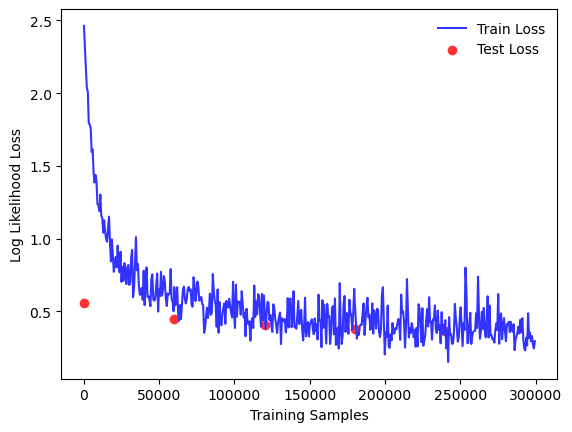

In [67]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [68]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/tmp/ipykernel_255/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

We are using torch.nograd() to make sure gradients are not being computed in this step. This is important because we don't want the network to train on the example_data from the test set that we are passing in. We simply want to see what the current model will output without altering it with the new data.

In [69]:
output.data

tensor([[ -8.6875, -10.5131,  -9.2775,  ...,  -8.4409,  -7.4675, -10.2256],
        [ -9.1144,  -2.4974,  -3.4454,  ...,  -2.7732,  -2.3991,  -0.7810],
        [ -8.7062, -12.1838,  -8.0954,  ...,  -6.0701,  -7.3619,  -2.7955],
        ...,
        [ -9.6310,  -7.4897,  -9.8215,  ...,  -5.9149,  -4.9771,  -0.7510],
        [ -7.4488,  -8.3181,  -6.1933,  ...,  -0.4986,  -5.4990,  -1.2440],
        [ -7.5585,  -8.7178,  -3.8631,  ...,  -6.9077,  -6.8742,  -6.6210]])

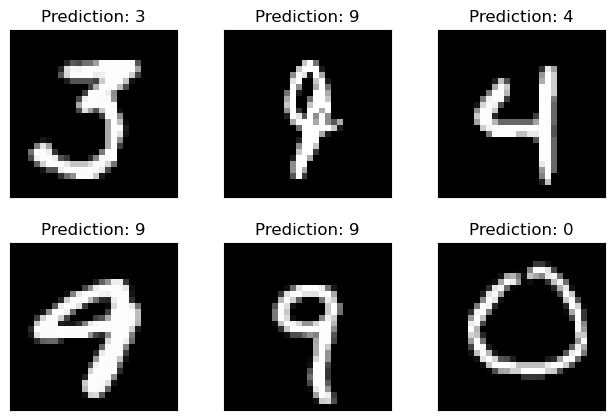

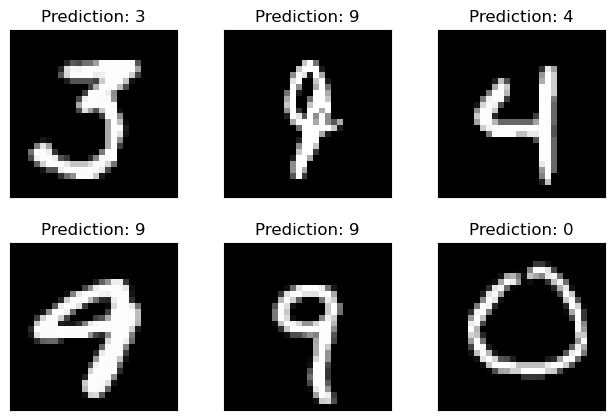

In [70]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

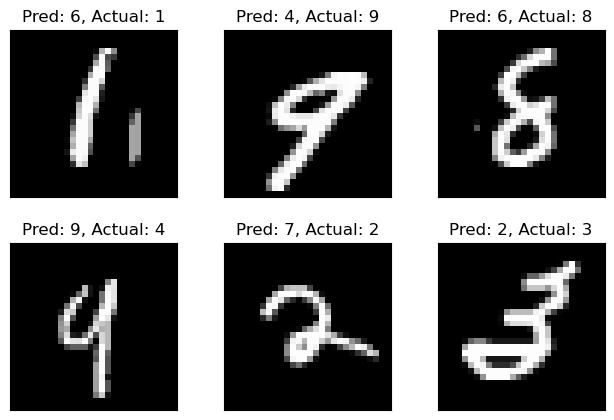

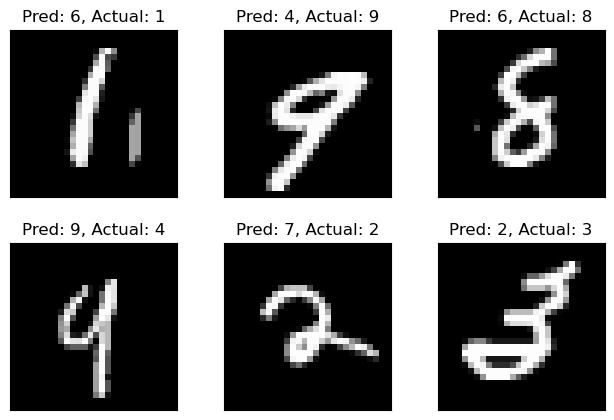

In [71]:
predictions = output.argmax(dim = 1)
mispreds_idx = [i for i in range(len(predictions)) if predictions[i] != example_targets[i]]

fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[mispreds_idx[i]][0], cmap='gray', interpolation='none')
    pl.title(f"Pred: {predictions[mispreds_idx[i]]}, Actual: {example_targets[mispreds_idx[i]]}")
    pl.xticks([])
    pl.yticks([])
fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [72]:
! ls results

model_iteration-0.pth  model_iteration-4.pth	  optimizer_iteration-2.pth
model_iteration-1.pth  model_iteration-5.pth	  optimizer_iteration-3.pth
model_iteration-2.pth  optimizer_iteration-0.pth  optimizer_iteration-4.pth
model_iteration-3.pth  optimizer_iteration-1.pth  optimizer_iteration-5.pth


To load a model:

In [73]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [74]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [75]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

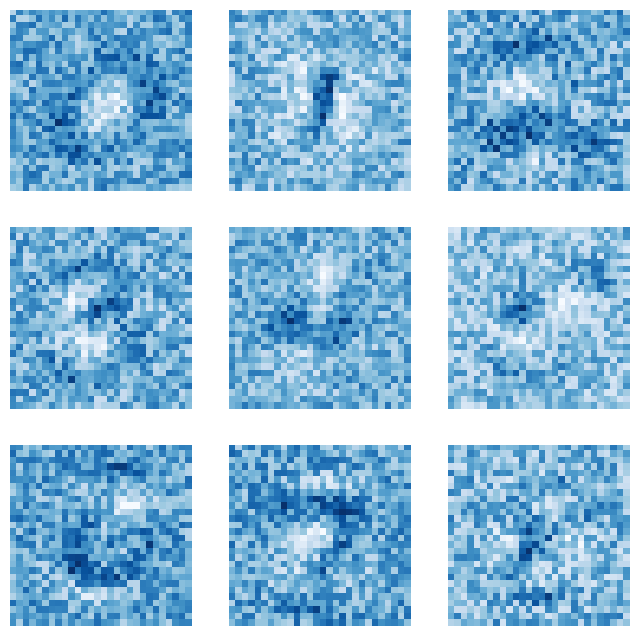

In [76]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [77]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [78]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

In [82]:
optimizer_state_dict['state']

{0: {'momentum_buffer': tensor([[-1.3096e-03, -1.3096e-03, -1.3096e-03,  ..., -1.3096e-03,
           -1.3096e-03, -1.3096e-03],
          [ 9.4565e-05,  9.4565e-05,  9.4565e-05,  ...,  9.4565e-05,
            9.4565e-05,  9.4565e-05],
          [ 7.4225e-03,  7.4225e-03,  7.4225e-03,  ...,  7.4225e-03,
            7.4225e-03,  7.4225e-03],
          ...,
          [-3.4549e-04, -3.4549e-04, -3.4549e-04,  ..., -3.4549e-04,
           -3.4549e-04, -3.4549e-04],
          [ 5.1118e-03,  5.1118e-03,  5.1118e-03,  ...,  5.1118e-03,
            5.1118e-03,  5.1118e-03],
          [-4.0428e-03, -4.0428e-03, -4.0428e-03,  ..., -4.0428e-03,
           -4.0428e-03, -4.0428e-03]])},
 1: {'momentum_buffer': tensor([ 3.0871e-03, -2.2292e-04, -1.7497e-02, -1.0883e-02,  1.6721e-02,
           3.4194e-05,  1.0465e-02,  8.1442e-04, -1.2050e-02,  9.5301e-03])}}

In [80]:
optimizer_state_dict['param_groups']

[{'lr': 0.001,
  'momentum': 0.1,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'params': [0, 1]}]

**Challenge:** Can you make sense of the data in this dictionary?

The 'state' key in the dictionary refers to the momentum buffers of each parameter id in the optimizer. As we know, momentum is a parameter that helps with convergence by using a fraction of prior gradients to make decisions. For this to occur, the information has to be kept somewhere for the network to have access to, hence it is being saved in the optimizer's 'state' dictionary. 

The 'param_groups' key in the dictionary referes to the different parameters that were initially passed into the feed forward neural network, such as learning rate, momentum, and weight_decay (L2). This keeps track of all the main parameters for quick access. 

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* What happens if you change parameters like the learning rate and momentum? Plot the difference.
* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

### What happens if you use only 10% of the available training data? Plot the difference in performance of the network.

In [29]:
train_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ]))

ten_percent = int(len(train_dataset) * 0.1)

ten_indices = random.sample(range(len(train_dataset)), ten_percent)

ten_train_dataset = torch.utils.data.Subset(train_dataset, ten_indices)

ten_train_loader = torch.utils.data.DataLoader(
    ten_train_dataset,
    batch_size=batch_size_train,
    shuffle=True)

ten_test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

ten_network = FeedforwardNeuralNetModel()
ten_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

! mkdir -p ten_results

n_epochs = 5
ten_train_losses = []
ten_train_counter = []
ten_test_losses = []
ten_test_counter = [i*len(ten_train_loader.dataset) for i in range(n_epochs + 1)]

def ten_train(epoch):
    ten_network.train()
    for batch_idx, (data, target) in enumerate(ten_train_loader):
        ten_optimizer.zero_grad() # clears gradients
        output = ten_network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(ten_train_loader.dataset),
                100. * batch_idx / len(ten_train_loader), loss.item())
            )
            ten_train_losses.append(loss.item())
            ten_train_counter.append((batch_idx*64) + ((epoch-1)*len(ten_train_loader.dataset)))
            torch.save(network.state_dict(), f'./ten_results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./ten_results/optimizer_iteration-{epoch}.pth')

def ten_test():
    ten_network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in ten_test_loader:
            output = ten_network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(ten_test_loader.dataset)
    ten_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(ten_test_loader.dataset), 100. * correct / len(ten_test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  ten_train(epoch)
  ten_test()

Train Epoch: 1 [0/6000 (0%)]	Loss: 2.383251


/tmp/ipykernel_280/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/6000 (11%)]	Loss: 2.260660
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.369394
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.319576
Train Epoch: 1 [2560/6000 (43%)]	Loss: 2.352642
Train Epoch: 1 [3200/6000 (53%)]	Loss: 2.339054
Train Epoch: 1 [3840/6000 (64%)]	Loss: 2.399627
Train Epoch: 1 [4480/6000 (74%)]	Loss: 2.362878
Train Epoch: 1 [5120/6000 (85%)]	Loss: 2.354085
Train Epoch: 1 [5760/6000 (96%)]	Loss: 2.303074

Test set: Avg. loss: 2.3690, Accuracy: 1395/10000 (14%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 2.128789
Train Epoch: 2 [640/6000 (11%)]	Loss: 2.224255
Train Epoch: 2 [1280/6000 (21%)]	Loss: 2.426590
Train Epoch: 2 [1920/6000 (32%)]	Loss: 2.359868
Train Epoch: 2 [2560/6000 (43%)]	Loss: 2.323963
Train Epoch: 2 [3200/6000 (53%)]	Loss: 2.411615
Train Epoch: 2 [3840/6000 (64%)]	Loss: 2.385204
Train Epoch: 2 [4480/6000 (74%)]	Loss: 2.436274
Train Epoch: 2 [5120/6000 (85%)]	Loss: 2.401446
Train Epoch: 2 [5760/6000 (96%)]	Loss: 2.341202

Test set: Avg. loss: 2.3690, Accura

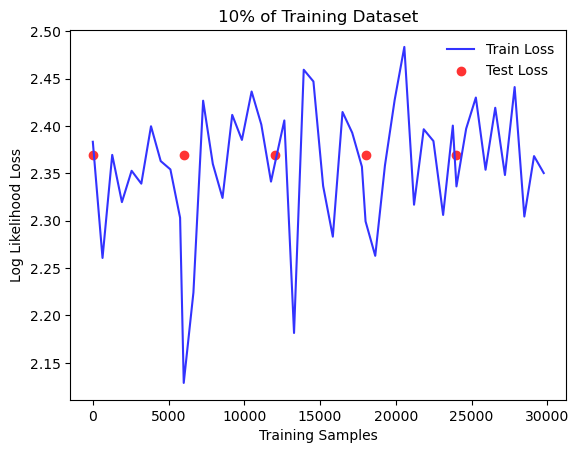

In [30]:
fig = pl.figure()
pl.plot(ten_train_counter, ten_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(ten_test_counter[:-1], ten_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.title('10% of Training Dataset')
pl.show()

As you can see from the chart above, when you only use 10% of the training data the network performace is significantly worse. This is likely due to the network not having enough examples to make the right predictions from learning from the mistakes (errors) since only 10% of the training data is being fed into it. 

### What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?

In [31]:
counts = {0: 0, 1: 0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for idx, target in enumerate(train_dataset.targets):
    counts[int(target)] += 1

In [32]:
label_5_20 = int(counts[5] * 0.20)
cur_5_count = 0
lab_5_idxs = []

for idx, target in enumerate(train_dataset.targets):
    if target == 5 and cur_5_count < label_5_20:
        lab_5_idxs.append(idx)
        cur_5_count += 1
    elif target != 5:
        lab_5_idxs.append(idx)

In [33]:
lab_5_dataset = torch.utils.data.Subset(train_dataset, lab_5_idxs)

lab_5_train_loader = torch.utils.data.DataLoader(
    lab_5_dataset,
    batch_size=batch_size_train,
    shuffle=True)

lab_5_test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

lab_5_network = FeedforwardNeuralNetModel()
lab_5_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

! mkdir -p lab_5_results

n_epochs = 5
lab_5_train_losses = []
lab_5_train_counter = []
lab_5_test_losses = []
lab_5_test_counter = [i*len(lab_5_train_loader.dataset) for i in range(n_epochs + 1)]


def lab_5_train(epoch):
    lab_5_network.train()
    for batch_idx, (data, target) in enumerate(lab_5_train_loader):
        lab_5_optimizer.zero_grad() # clears gradients
        output = lab_5_network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(lab_5_train_loader.dataset),
                100. * batch_idx / len(lab_5_train_loader), loss.item())
            )
            lab_5_train_losses.append(loss.item())
            lab_5_train_counter.append((batch_idx*64) + ((epoch-1)*len(lab_5_train_loader.dataset)))
            torch.save(network.state_dict(), f'./lab_5_results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./lab_5_results/optimizer_iteration-{epoch}.pth')

def lab_5_test():
    lab_5_network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in lab_5_test_loader:
            output = lab_5_network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(lab_5_test_loader.dataset)
    lab_5_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(lab_5_test_loader.dataset), 100. * correct / len(lab_5_test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  lab_5_train(epoch)
  lab_5_test()

Train Epoch: 1 [0/55663 (0%)]	Loss: 2.587368


/tmp/ipykernel_280/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/55663 (1%)]	Loss: 2.468262
Train Epoch: 1 [1280/55663 (2%)]	Loss: 2.620874
Train Epoch: 1 [1920/55663 (3%)]	Loss: 2.623209
Train Epoch: 1 [2560/55663 (5%)]	Loss: 2.520447
Train Epoch: 1 [3200/55663 (6%)]	Loss: 2.523913
Train Epoch: 1 [3840/55663 (7%)]	Loss: 2.542612
Train Epoch: 1 [4480/55663 (8%)]	Loss: 2.572625
Train Epoch: 1 [5120/55663 (9%)]	Loss: 2.434397
Train Epoch: 1 [5760/55663 (10%)]	Loss: 2.444145
Train Epoch: 1 [6400/55663 (11%)]	Loss: 2.490224
Train Epoch: 1 [7040/55663 (13%)]	Loss: 2.530245
Train Epoch: 1 [7680/55663 (14%)]	Loss: 2.482679
Train Epoch: 1 [8320/55663 (15%)]	Loss: 2.524312
Train Epoch: 1 [8960/55663 (16%)]	Loss: 2.607999
Train Epoch: 1 [9600/55663 (17%)]	Loss: 2.569518
Train Epoch: 1 [10240/55663 (18%)]	Loss: 2.422970
Train Epoch: 1 [10880/55663 (20%)]	Loss: 2.439910
Train Epoch: 1 [11520/55663 (21%)]	Loss: 2.538823
Train Epoch: 1 [12160/55663 (22%)]	Loss: 2.533462
Train Epoch: 1 [12800/55663 (23%)]	Loss: 2.612360
Train Epoch: 1 [13440/55

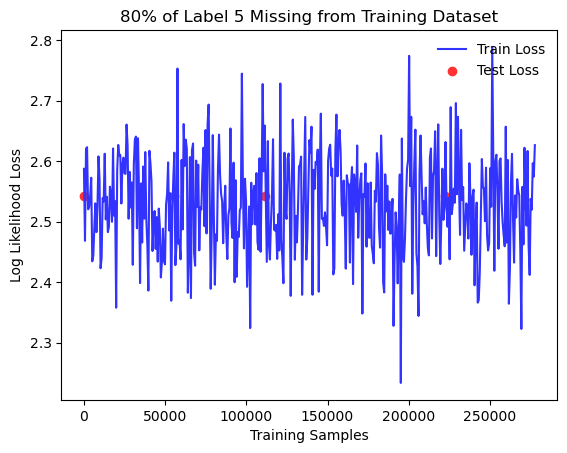

In [34]:
fig = pl.figure()
pl.plot(lab_5_train_counter, lab_5_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(lab_5_test_counter[:-1], lab_5_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.title('80% of Label 5 Missing from Training Dataset')
pl.show()

As you can see from the chart above, when you only remove 80% of the training data with label 5 the network performace is worse. The results seem to be somewhat homologous with that of the results from the previous problem in terms of the low accuracy, even though there is more data that the model is being trained on. While there is a lot more data that the network is being trained, since there is a large amount of bias in the data, the network fails to make accurate predictions due to unfamiliarity with the label 5, which not only throws of predictions of label 5 but the rest of the labels also.

### What happens if you change parameters like the learning rate and momentum? Plot the difference.

#### Learning Rate (0.0001) < Baseline (0.001)

In [25]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

learning_rate = 0.0001
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.447888


/tmp/ipykernel_285/43663745.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.447205
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.515204
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.433845
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.430782
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.249251
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.287362
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.380019
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.330768
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.366168
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.377198
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.276826
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.226607
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.267187
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.277109
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.172819
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.350533
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.214758
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.236973
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.214969
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.182539
Train Epoch: 1 [13440/60

#### Learning Rate (0.05) > Baseline (0.001)

In [26]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

learning_rate = 0.05
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

more_train_losses = []
more_train_counter = []
more_test_losses = []
more_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            more_train_losses.append(loss.item())
            more_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    more_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.223733


/tmp/ipykernel_285/3920354857.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 0.928794
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.546773
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.654573
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.404552
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.457835
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.419503
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.533923
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.425286
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.557502
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.165428
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.297981
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.558849
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.223125
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.218144
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.295642
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.300978
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.365512
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.470933
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.386813
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.277192
Train Epoch: 1 [13440/60

#### Momentum (0.005) < Baseline (0.1)

In [27]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

learning_rate = 0.0001
momentum = 0.005
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

less_m_train_losses = []
less_m_train_counter = []
less_m_test_losses = []
less_m_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_m_train_losses.append(loss.item())
            less_m_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_m_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370393


/tmp/ipykernel_285/2498531456.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.317198
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.365346
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.359110
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.403814
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.337439
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.470490
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.455724
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.307595
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.346207
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.359171
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.461463
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.347367
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.368580
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.305956
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.359329
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.269050
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.276701
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.384036
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.257910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.241470
Train Epoch: 1 [13440/60

#### Momentum (0.5) > Baseline (0.1)

In [28]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

learning_rate = 0.05
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

more_m_train_losses = []
more_m_train_counter = []
more_m_test_losses = []
more_m_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            more_m_train_losses.append(loss.item())
            more_m_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    more_m_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.417288


/tmp/ipykernel_285/2916218825.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 0.611135
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.589362
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.573495
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.435814
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.430539
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.423576
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.523100
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.387472
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.389874
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.363675
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.479456
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.324632
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.281525
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.456686
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.318629
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.549614
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.349725
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.299844
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.367937
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.427946
Train Epoch: 1 [13440/60

#### Plotting Charts For Differences

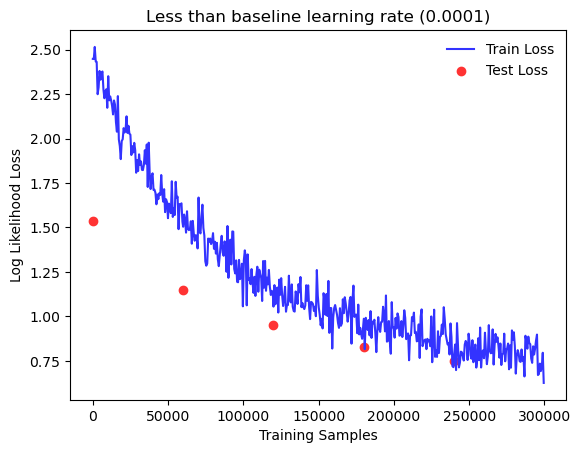

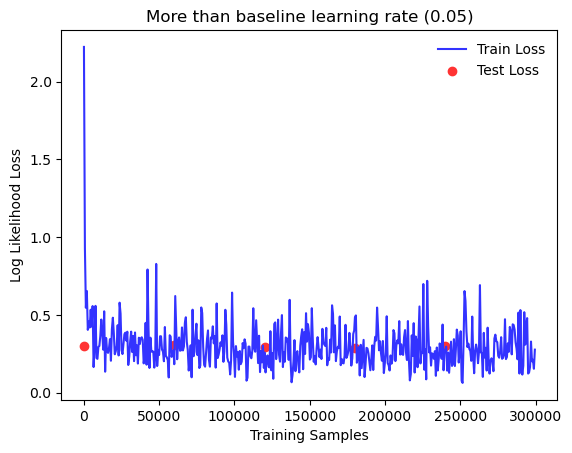

In [37]:
fig = pl.figure()
pl.plot(less_train_counter, less_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(less_test_counter[:-1], less_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title('Less than baseline learning rate (0.0001)')

pl.show()

fig = pl.figure()
pl.plot(more_train_counter, more_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(more_test_counter[:-1], more_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title('More than baseline learning rate (0.05)')

pl.show()

##### Learning Rate Takeways
My takeway from training a neural networks on different learning rates, both below and above the baseline of 0.001 is that lower learning rate is a slower to converge, but has more stability. A higher learning rate is a lot faster to converge, but it is very unstable and even though from a numerical assessment of accuracy is better than a smaller learning rate, it shouldn't be trusted as much.  

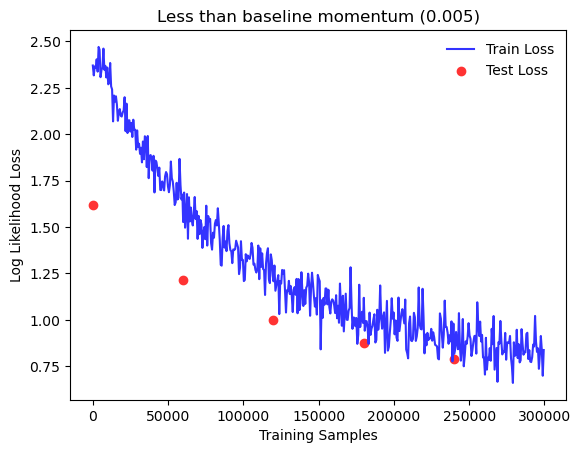

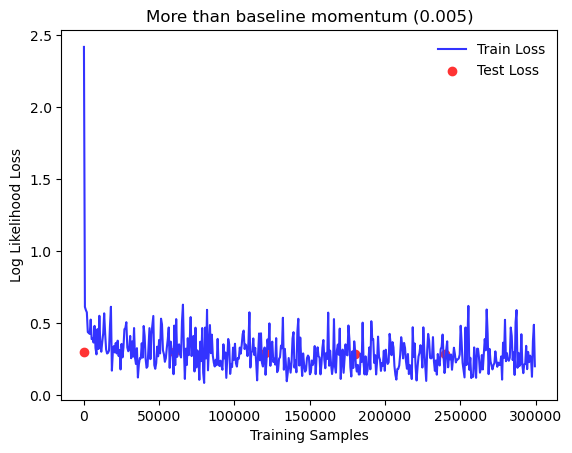

In [38]:
fig = pl.figure()
pl.plot(less_m_train_counter, less_m_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(less_m_test_counter[:-1], less_m_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title('Less than baseline momentum (0.005)')

pl.show()

fig = pl.figure()
pl.plot(more_m_train_counter, more_m_train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(more_m_test_counter[:-1], more_m_test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title('More than baseline momentum (0.005)')

pl.show()

##### Momentum Takeways
My takeway from training a neural networks on different momentums, both below and above the baseline of 0.1 is that lower momentum is a slower to converge, but has more stability. A higher learning rate is a lot faster to converge, but it is very unstable and even though from a numerical assessment of accuracy is better than a smaller momentum, it shouldn't be trusted. The relationship between learning rates and momentum seem to parallel each other  

### Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?

#### One Hidden Layer

In [21]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim = int(2/3 * input_dim) + 10
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return F.log_softmax(out, dim=1)

learning_rate = 0.001
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

hid_1_accuracy = []

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    hid_1_accuracy.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.381660
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.349535
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.348694
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.318109
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.310035
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.277648
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.239803
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.209265
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.179166
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.094861
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.114924
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.137740
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.077794
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.020093
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.059700
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.078665
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.966597
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.971864
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.964267
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.902773
Train Epoch: 1 [12800/60000 (

#### Two Hidden Layers

In [25]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim1 = int(2/3 * input_dim) + 10
        hidden_dim2 = int(2/3 * hidden_dim1) + 10
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return F.log_softmax(out, dim=1)

learning_rate = 0.001
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

hid_2_accuracy = []

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    hid_2_accuracy.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298120
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.294860
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.276601
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.291367
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.280792
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.292662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.291306
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.277231
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.264263
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.260026
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.245878
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.265574
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.254715
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.250502
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.228765
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.263445
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.219166
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.220626
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.201568
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.207543
Train Epoch: 1 [12800/60000 (

#### Three Hidden Layers

In [34]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim1 = int(2/3 * input_dim) + 10
        hidden_dim2 = int(2/3 * hidden_dim1) + 10
        hidden_dim3 = int(2/3 * hidden_dim2) + 10
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return F.log_softmax(out, dim=1)

learning_rate = 0.001
momentum = 0.1
log_interval = 10

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

hid_3_accuracy = []

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    hid_3_accuracy.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304032
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.308850
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.309067
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.305060
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.306476
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.301790
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.301017
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.301322
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.292714
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.297730
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.299654
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.294617
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.295508
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.289464
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.291932
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.287523
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.288608
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.291683
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.290447
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.287947
Train Epoch: 1 [12800/60000 (

Some interesting changes I found was a decrease in accuracy with the more hidden layers I add. Initially, this was very surprising for me, but after thinking more critically of the measurement of accuracy, I realized that it is probably due to overfitting on the training data with the more hidden layers I add. This is probably why the network with no hidden layers performs better than the network with 3 hidden layers. Another factor could definetely be the limited amount of data the network has to train on, which can affect the hidden layers.

#### Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?

#### L1 = 0.001, L2 = 0.001, Dropout Rate = 0.5

In [33]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim = int(2/3 * input_dim) + 10
        num_classes = 10
        dropout_rate = 0.5
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return F.log_softmax(out, dim = 1)
        
learning_rate = 0.001
momentum = 0.1
log_interval = 10
L1 = 0.001
L2 = 0.001

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay = L2)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)

        L1_reg = torch.tensor(0.)
        for param in network.parameters():
            L1_reg += torch.norm(param, 1)
        loss += L1 * L1_reg
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

reg_accuracy = []

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    reg_accuracy.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 9.999038
Train Epoch: 1 [640/60000 (1%)]	Loss: 9.989028
Train Epoch: 1 [1280/60000 (2%)]	Loss: 9.866488
Train Epoch: 1 [1920/60000 (3%)]	Loss: 9.886829
Train Epoch: 1 [2560/60000 (4%)]	Loss: 9.779105
Train Epoch: 1 [3200/60000 (5%)]	Loss: 9.739048
Train Epoch: 1 [3840/60000 (6%)]	Loss: 9.823114
Train Epoch: 1 [4480/60000 (7%)]	Loss: 9.775677
Train Epoch: 1 [5120/60000 (9%)]	Loss: 9.749796
Train Epoch: 1 [5760/60000 (10%)]	Loss: 9.701211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.621674
Train Epoch: 1 [7040/60000 (12%)]	Loss: 9.661496
Train Epoch: 1 [7680/60000 (13%)]	Loss: 9.562511
Train Epoch: 1 [8320/60000 (14%)]	Loss: 9.634895
Train Epoch: 1 [8960/60000 (15%)]	Loss: 9.571336
Train Epoch: 1 [9600/60000 (16%)]	Loss: 9.580435
Train Epoch: 1 [10240/60000 (17%)]	Loss: 9.514739
Train Epoch: 1 [10880/60000 (18%)]	Loss: 9.521755
Train Epoch: 1 [11520/60000 (19%)]	Loss: 9.465865
Train Epoch: 1 [12160/60000 (20%)]	Loss: 9.413177
Train Epoch: 1 [12800/60000 (

#### L1 = 0.0001, L2 = 0.0001, Dropout Rate = 0.3

In [85]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim = int(2/3 * input_dim) + 10
        num_classes = 10
        dropout_rate = 0.3
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return F.log_softmax(out, dim = 1)
        
learning_rate = 0.001
momentum = 0.1
log_interval = 10
L1 = 0.0001
L2 = 0.0001

network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay = L2)

n_epochs = 5

less_train_losses = []
less_train_counter = []
less_test_losses = []
less_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

! mkdir -p results

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)

        L1_reg = torch.tensor(0.)
        for param in network.parameters():
            L1_reg += torch.norm(param, 1)
        loss += L1 * L1_reg
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            less_train_losses.append(loss.item())
            less_train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

reg_accuracy = []

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    less_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )
    reg_accuracy.append(100. * correct / len(test_loader.dataset))

for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.089041
Train Epoch: 1 [640/60000 (1%)]	Loss: 3.085520
Train Epoch: 1 [1280/60000 (2%)]	Loss: 3.045051
Train Epoch: 1 [1920/60000 (3%)]	Loss: 3.026793
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.976428
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.992555
Train Epoch: 1 [3840/60000 (6%)]	Loss: 3.052438
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.898000
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.854602
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.864952
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.897651
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.859497
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.814370
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.783883
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.814785
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.685907
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.795823
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.665278
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.679433
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.703863
Train Epoch: 1 [12800/60000 (

One of the biggest changes I observed when adding in L1, L2, and dropout reguralization into the network with one hidden layer, was that the loss and average loss was significantly higher, but the accuracy stayed the same 90% (both with and without regularization) by epoch 5, which is really interesting to see. 

In the second example, I decreased L1 and L2 from 0.001 to 0.0001 and the dropout rate from 50% to 30%. Making this change, helped make 23 more correct predicitions and decreased the average loss down to 0.3754. If I were to find the optimal parameters for the network, I would decrease L1 and L2 a little more and try different values 